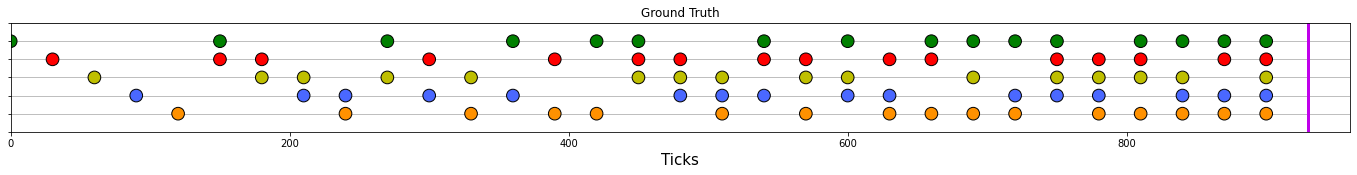

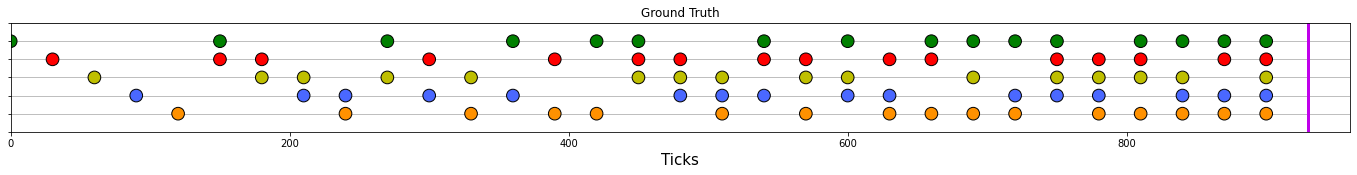

In [2]:
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent.parent))
from tensor_hero.visualization import plot_chart
import numpy as np

notes_array = np.zeros(shape=(32*30,))
new_encoding = {
    1 : 1,
    2 : 2,
    3 : 3,
    4 : 4,
    5 : 5,
    6 : 6,
    7 : 10,
    8 : 13,
    9 : 15,
    10 : 7,
    11 : 11,
    12 : 14,
    13 : 8,
    14 : 12,
    15 : 9,
    16 : 16,
    17 : 22,
    18 : 25,
    19 : 17,
    20 : 23,
    21 : 19,
    22 : 24,
    23 : 18,
    24 : 20,
    25 : 21,
    26 : 26,
    27 : 30,
    28 : 27,
    29 : 29,
    30 : 28,
    31 : 31,
    32 : 218
}

for i in range(32):
    notes_array[i*30] = new_encoding[i+1]
    
plot_chart(notes_array)

## How to encode a notes array

We have 13 possible note categories:
1. $s$ : single - Single notes
    - $s[0]$ = G
    - $s[1]$ = R
    - $s[2]$ = Y
    - $s[3]$ = B
    - $s[4]$ = O
2. $d0$ : double 0 - Double notes with 0 spaces between them
    - $d0[0]$ = GR
    - $d0[1]$ = RY
    - $d0[2]$ = YB
    - $d0[3]$ = BO
3. $d1$ : double 1 - Double notes with 1 space between them
    - $d1[0]$ = GY
    - $d1[1]$ = RB
    - $d1[2]$ = YO
4. $d2$ : double 2 - Double notes with 2 spaces between them
    - $d2[0]$ = GB
    - $d2[1]$ = RO
5. $d3$ : double 3 - Double notes with 3 spaces between them
    - $d3[0]$ = GO
6. $t0$ : triple 0 - Triple notes with 0 spaces between them
    - $t0[0]$ = GRY
    - $t0[1]$ = RYB
    - $t0[2]$ = YBO
7. $t1$ : triple 1 - Triple notes with 1 space between the 2nd and 3rd highest note
    - $t1[0]$ = GRB
    - $t1[1]$ = RYO
8. $t2$ : triple 2 - Triple notes with 1 spaces between the 1st and 2nd highest note
    - $t2[0]$ = GYB
    - $t2[1]$ = RBO
9. $t3$ : triple 3 - Triple notes with 2 spaces between all of the notes
    - $t3[0]$ = GRO
    - $t3[1]$ = GYO
    - $t3[2]$ = GBO
10. $q0$ : quad 0 - Quad notes with 0 spaces in between
    - $q0[0]$ = GRYB
    - $q0[1]$ = RYBO
11. $q1$ : quad 1 - Quad notes with 1 space in between
    - $q1[0]$ = GRYO
    - $q1[1]$ = GRBO
    - $q1[2]$ = GYBO
12. $p$ : pent - All notes held simultaneously
    - $p[0]$ = GRYBO
13. $o$ : open - Open note
    - $o[0]$ = open



![](2022-04-15-17-46-59.png)

|   Note Category   | Motion | Anchor     |
| :---:        |    :----:   |          :---: |
|     $C$      | $m$       | $a$   |

### Note Category $C$
- Describes the category of note as described above
- $\vert C \vert = 13$, there are 13 possible categories
### Motion $m$
- Describes the change in the anchor between subsequent notes
- For example, if the anchor is at $0$ and the motion is $+4$, the anchor of the next note would be 4
- $m \in [-4, 4]$, the motion will be between -4 and 4
### Anchor $a$
- Each note category, $C$, has indices describing notes within it. The anchor can be viewed as the index of the note category. Taken together, the note category and anchor together describe a single note
- For example, in a prediction scenario, if $a=2$ is the predicted anchor and $C = d1$ is the predicted note category, the note would be $d1[2] = $ YO
- $a \in [0, 4]$, $\vert A \vert = 5$
### Outer Limit Considerations for decoding
#### 1. The anchor is larger than the size of the note category
For single notes, 5 anchor values describes every possibility. However, for other note categories, there are less than 5 notes.

Please note that even though $\vert A \vert = 5$, its maximum value is $4$ because of 0 indexing

What do we do when $a=4$ and $C=d1$? $d1[4]$ doesn't exist so instead we translate the anchor to the minimum of $(a, \vert d1 \vert - 1)$ *(the minus 1 is for 0 indexing)*.

In this case, $a=4$, $\vert d1 \vert - 1$ = 2, so we we change the anchor to $a=2$, and the new note is $d1[2] = $ YO. This is an absolute change for most note categories, the next predicted motion will apply to the translated anchor.

*exception*: If the note category is $open$, $pent$, $quad$, or $d3$ the anchor will go back to its previous position rather than being reset to $\vert C_{i} \vert - 1$. This is because there isn't an inherent direction implied in the notes contained in these categories.

#### 2. The motion sets the anchor outside of its range
If the anchor is set at $4$, and the motion predicts $+1$, we wrap the anchor back to $0$ rather than setting it to 5

Notable, this rather than taking the modulo of the predicted value, we set negative anchors to $\max(A) = 4$, and anchors $>4$ to $\min(A) = 0$

This is because taking the modulo could result in a situation where we have something like O -> B on an ascending scale rather than O -> G like it should be


## Encoding procedure

1. Translate each note to a note category and an anchor
    - G -> Y -> B is translated to $s[0]$ -> $s[2]$ -> $s[3]$
2. Extract the anchors and use their relative distance to calculate the motion, $m$
    - Note: We currently choose 0 as the default start anchor.
    - $start$ -> $s[0]$ -> $s[2]$ -> $s[3]$ is translated to $(0-0)$ -> $(2-0)$ -> $(3-2) =$  $0$ -> $2$ -> $1$
3. The final notes array is encoded as a 2D numpy matrix, $contour$, shape = $(2, \text{length of song in ms})$
    - $contour[0,:]$ contains a key for the note category, $C$
    - $contour[1,:]$ contains the corresponding motions at each onset
        - Time bins without note events are filled with 0s

### Note Category Keys
{ \
    1 : $s$ \
    2 : $d0$ \
    3 : $d1$ \
    4 : $d2$ \
    5 : $d3$ \
    6 : $t0$ \
    7 : $t1$ \
    8 : $t2$ \
    9 : $t3$ \
    10 : $q0$ \
    11 : $q1$ \
    12 : $p$ \
    13 : $o$ \
}


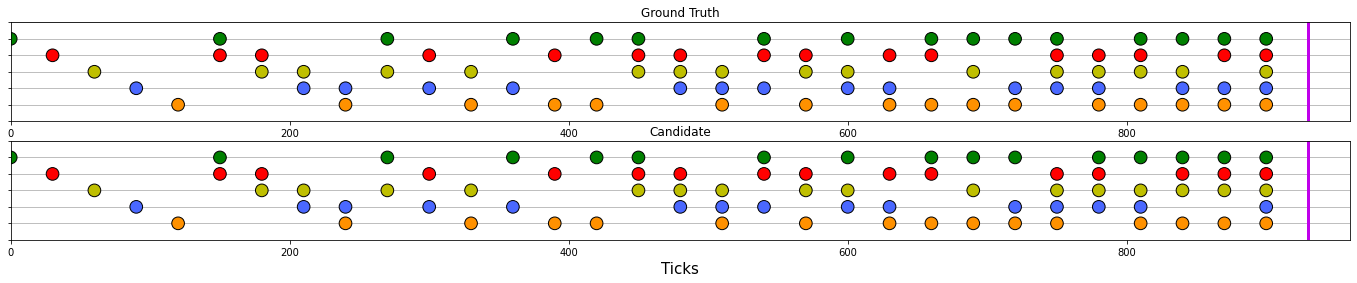

In [11]:
# Describes an easier way to index specific notes for the purpose of note category grouping
# keys = more organized grouping for notes
# values = original simplified note array representation
note_category_grouping = {
    1 : 1,
    2 : 2,
    3 : 3,
    4 : 4,
    5 : 5,
    6 : 6,
    7 : 10,
    8 : 13,
    9 : 15,
    10 : 7,
    11 : 11,
    12 : 14,
    13 : 8,
    14 : 12,
    15 : 9,
    16 : 16,
    17 : 22,
    18 : 25,
    19 : 17,
    20 : 23,
    21 : 19,
    22 : 24,
    23 : 18,
    24 : 20,
    25 : 21,
    26 : 26,
    27 : 30,
    28 : 27,
    29 : 29,
    30 : 28,
    31 : 31,
    32 : 218
}
notes_to_note_category_grouping = dict([(v,k) for k,v in note_category_grouping.items()])

# keys = note category grouping organized notes
# values = note category encoding
notes_to_note_category = {
    1 : 1, # s
    2 : 1,
    3 : 1,
    4 : 1,
    5 : 1,
    6 : 2, # d0
    7 : 2,
    8 : 2,
    9 : 2,
    10 : 3, # d1
    11 : 3,
    12 : 3,
    13 : 4, # d2
    14 : 4,
    15 : 5, # d3
    16 : 6, # t0
    17 : 6,
    18 : 6,
    19 : 7, # t1
    20 : 7,
    21 : 8, # t2
    22 : 8,
    23 : 9, # t3
    24 : 9,
    25 : 9,
    26 : 10, # q0
    27 : 10,
    28 : 11, # q1
    29 : 11,
    30 : 11,
    31 : 12, # p
    32 : 13  # o
}

cardinality_of_note_categories = {
    1 : 5,
    2 : 4,
    3 : 3,
    4 : 2,
    5 : 1,
    6 : 3,
    7 : 2,
    8 : 2,
    9 : 3,
    10 : 2,
    11 : 3,
    12 : 1,
    13 : 1
}

# We use note category grouping of note to describe it
note_category_to_note = {
    1 : [1, 2, 3, 4, 5],
    2 : [6, 7, 8, 9],
    3 : [10, 11, 12],
    4 : [13, 14],
    5 : [15],
    6 : [16, 17, 18],
    7 : [19, 20],
    8 : [21, 22],
    9 : [23, 24, 25],
    10 : [26, 27],
    11 : [28, 29, 30],
    12 : [31],
    13 : [32]
}

# The note category encoded notes and their corresponding anchors
notes_to_anchor = {
    1 : 0,  # s[0]
    2 : 1,  # s[1]
    3 : 2,
    4 : 3,
    5 : 4,
    6 : 0,  # d0[0]
    7 : 1,  # d0[1]
    8 : 2,
    9 : 3,
    10 : 0,
    11 : 1,
    12 : 2,
    13 : 0,
    14 : 1,
    15 : 0,
    16 : 0,
    17 : 1,
    18 : 2,
    19 : 0,
    20 : 1,
    21 : 0,
    22 : 1,
    23 : 0,
    24 : 1,
    25 : 2,
    26 : 0,
    27 : 1,
    28 : 0,
    29 : 1,
    30 : 2,
    31 : 0,
    32 : 0,
}

# Includes open, pent, quad, and d3 notes
back_to_prev_anchor_notes = [15, *list(range(26,33))]

def encode_contour(notes_array):
    '''
    Takes a notes array and encodes the contour as described in ../Documentation/contour.md

    ~~~~ ARGUMENTS ~~~~
    - notes_array (1D numpy array): Simplified notes array
        - shape = (1, length of song in 10ms bines)
        
    ~~~~ RETURNS ~~~~
    - contour (2D numpy array): Encoded notes_array
        - shape = (2, length of song in 10ms bines)
        - contour[0,:] contains a key for the note category, C
        - contour[1,:] contains the corresponding motions at each onset
        - Time bins without note events are filled with 0s
    '''
    contour = np.zeros(shape=(2, notes_array.shape[0]))
    note_indices = np.where(notes_array > 0)[0]
    
    prev_anchor = 0   # We set the initial anchor at the green note, a=0
    for note_idx in note_indices:
        # Populate contour with note categories
        contour[0, note_idx] = notes_to_note_category[notes_to_note_category_grouping[int(notes_array[note_idx])]]

        # Populate contour with relative motion
        if notes_to_note_category_grouping[int(notes_array[note_idx])] in back_to_prev_anchor_notes:
            contour[1, note_idx] = 0
        else:
            new_anchor = notes_to_anchor[notes_to_note_category_grouping[int(notes_array[note_idx])]]
            contour[1, note_idx] = new_anchor - prev_anchor
            prev_anchor = new_anchor
            # print(f'\n{contour[0, note_idx]}')
            # print(contour[1, note_idx])
    
    # print(note_indices)
    # print(contour.shape)
    return contour

contour = encode_contour(notes_array)

def decode_contour(contour):
    '''
    Takes an encoded contour array and decodes it into a simplified notes array
    
    ~~~~ ARGUMENTS ~~~~
    - contour (2D numpy array): Encoded notes_array
        - shape = (2, length of song in 10ms bins)
        - contour[0,:] contains a key for the note category, C
        - contour[1,:] contains the corresponding motions at each onset
        - Time bins without note events are filled with 0s
    
    ~~~~ RETURNS ~~~~
    - notes_array (1D numpy array): Decoded simplified notes_array
        - shape = (1, length of song in 10ms bins)
    '''
    # print(f'contour shape: {contour.shape}')
    notes_array = np.zeros(shape=(contour.shape[1]))
    
    # Loop through note categories in contour, adjusting anchor along the way
    note_indices = np.where(contour[0] > 0)[0].astype(int)
    anchor = 0  # Initialize anchor
    for note_idx in note_indices:
        if not int(contour[0,note_idx]) in [5, 10, 11, 12, 13]:  # If not d3, quad, pent, or open
            anchor = anchor+int(contour[1,note_idx])
            if anchor > cardinality_of_note_categories[int(contour[0,note_idx])]-1:  # Wrap around
                anchor = 0
            elif anchor < 0:
                anchor = cardinality_of_note_categories[int(contour[0,note_idx])]-1
            anchor = min(anchor, cardinality_of_note_categories[int(contour[0,note_idx])]-1)
            notes_array[note_idx] = note_category_grouping[note_category_to_note[int(contour[0,note_idx])][anchor]]
        else:
            # choose at random for these note categories
            temp_anchor = np.random.randint(0, cardinality_of_note_categories[int(contour[0,note_idx])])  
            notes_array[note_idx] = note_category_grouping[note_category_to_note[int(contour[0,note_idx])][temp_anchor]]

    return notes_array

decoded_notes_array = decode_contour(contour)

_ = plot_chart(ground_truth=notes_array, candidate=decoded_notes_array)         
    

Try it out on some real data

[0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 2, 1, 0, 3, 1, 2, 4, 3, 1, 3, 1, 0, 2, 2, 1, 0, 3, 1, 2, 4, 3, 2, 1, 0, 2, 2, 1, 0, 3, 1, 2, 4, 3, 1, 3, 1, 0, 2, 2, 1, 0, 3, 1, 2, 4, 3, 2, 3, 4, 2, 1, 0, 3, 1, 2, 4, 3, 1, 3, 1, 0, 2, 2, 1, 0, 3, 1, 2, 4, 3, 2, 0, 2, 2, 1, 0, 3, 1, 2, 4, 3, 1, 3, 1, 0, 2, 2, 1, 0, 3, 1, 2, 4, 3, 2, 3, 4, 2, 0, 0, 0, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 3, 2, 0, 3, 2, 0, 4, 0, 1, 2, 3, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 2, 3, 2, 0, 3, 2, 0, 4, 0, 1, 2, 3, 2, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 2, 3, 2, 0, 3, 2, 0, 4, 0, 1, 2, 3, 1, 0, 1, 2, 0, 1, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 2, 1, 0, 3, 0, 1, 2, 1, 0, 0, 2, 3, 0, 3, 2, 0, 4, 0, 2, 3, 2, 0, 1, 2, 3, 1, 3, 2, 1, 4, 1, 2, 3, 2, 1, 0, 3, 2, 0, 4, 1, 2, 3, 2, 1, 0, 2, 1, 0, 3, 1, 2, 4, 3, 1, 3, 1, 0, 2, 2, 1, 0, 3, 1, 2, 4, 3, 2, 1, 0, 2, 2, 1, 0, 3, 1, 2, 4, 3, 1, 3, 1, 0, 2, 2, 1, 0, 3, 1, 2, 4, 3, 2, 3, 4, 2, 0, 0, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 3, 2, 0, 3, 2, 0, 4, 0, 1, 2, 3, 

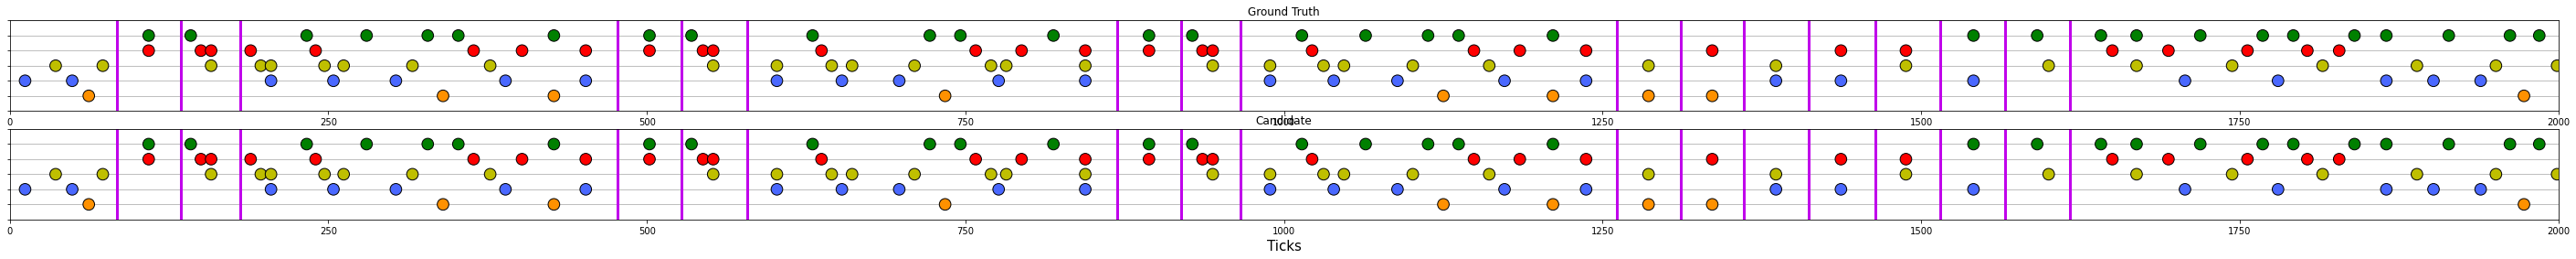

In [10]:
real_notes_array = np.load(Path.cwd().parent.parent / 'example_song' / 'notes_simplified.npy')
real_contour = encode_contour(real_notes_array)
real_contour_decoded = decode_contour(real_contour)

_ = plot_chart(real_notes_array[11000:13000], real_contour_decoded[11000:13000])

## Next things to do:
- Try out the modulo operator rather than the static wrap to see if it performs better
- Maybe decode the notes array with every anchor as a start and minimize the number of O->G and G->O jumps to optimize
    - Doing the modulo thing rather than static wrap could solve this
- Figure out why d0 keeps returning two of the same chords in a row even though it should change